# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 921us/sample - loss: 277.0345 - y1_output_loss: 122.0571 - y2_output_loss: 152.7179 - y1_output_root_mean_squared_error: 11.0951 - y2_output_root_mean_squared_error: 12.4070 - val_loss: 61.5748 - val_y1_output_loss: 19.9995 - val_y2_output_loss: 39.7639 - val_y1_output_root_mean_squared_error: 4.5454 - val_y2_output_root_mean_squared_error: 6.3964
Epoch 2/500
614/614 [==============================] - 0s 144us/sample - loss: 31.6814 - y1_output_loss: 12.4928 - y2_output_loss: 19.1554 - y1_output_root_mean_squared_error: 3.5288 - y2_output_root_mean_squared_error: 4.3851 - val_loss: 30.5231 - val_y1_output_loss: 13.5387 - val_y2_output_loss: 16.6410 - val_y1_output_root_mean_squared_error: 3.7082 - val_y2_output_root_mean_squared_error: 4.0954
Epoch 3/500
614/614 [==============================] - 0s 141us/sample - loss: 28.1002 - y1_output_loss: 10.2059 - y2_output_loss: 17.8144 - y1

614/614 [==============================] - 0s 135us/sample - loss: 14.4937 - y1_output_loss: 5.5704 - y2_output_loss: 8.9352 - y1_output_root_mean_squared_error: 2.3546 - y2_output_root_mean_squared_error: 2.9915 - val_loss: 14.0318 - val_y1_output_loss: 7.0209 - val_y2_output_loss: 6.7467 - val_y1_output_root_mean_squared_error: 2.6807 - val_y2_output_root_mean_squared_error: 2.6164
Epoch 22/500
614/614 [==============================] - 0s 134us/sample - loss: 15.7965 - y1_output_loss: 5.6871 - y2_output_loss: 10.0431 - y1_output_root_mean_squared_error: 2.3812 - y2_output_root_mean_squared_error: 3.1822 - val_loss: 21.0053 - val_y1_output_loss: 7.9700 - val_y2_output_loss: 12.5141 - val_y1_output_root_mean_squared_error: 2.8668 - val_y2_output_root_mean_squared_error: 3.5759
Epoch 23/500
614/614 [==============================] - 0s 136us/sample - loss: 15.0213 - y1_output_loss: 5.4234 - y2_output_loss: 9.5373 - y1_output_root_mean_squared_error: 2.3349 - y2_output_root_mean_squared

614/614 [==============================] - 0s 141us/sample - loss: 12.7730 - y1_output_loss: 4.3728 - y2_output_loss: 8.3165 - y1_output_root_mean_squared_error: 2.1000 - y2_output_root_mean_squared_error: 2.8919 - val_loss: 20.8364 - val_y1_output_loss: 5.4857 - val_y2_output_loss: 14.9070 - val_y1_output_root_mean_squared_error: 2.3665 - val_y2_output_root_mean_squared_error: 3.9033
Epoch 42/500
614/614 [==============================] - 0s 153us/sample - loss: 8.0456 - y1_output_loss: 2.4048 - y2_output_loss: 5.6215 - y1_output_root_mean_squared_error: 1.5528 - y2_output_root_mean_squared_error: 2.3737 - val_loss: 6.7957 - val_y1_output_loss: 2.5099 - val_y2_output_loss: 4.0846 - val_y1_output_root_mean_squared_error: 1.6070 - val_y2_output_root_mean_squared_error: 2.0527
Epoch 43/500
614/614 [==============================] - 0s 141us/sample - loss: 7.9740 - y1_output_loss: 2.5036 - y2_output_loss: 5.4534 - y1_output_root_mean_squared_error: 1.5833 - y2_output_root_mean_squared_err

Epoch 62/500
614/614 [==============================] - 0s 136us/sample - loss: 7.4097 - y1_output_loss: 1.9476 - y2_output_loss: 5.4437 - y1_output_root_mean_squared_error: 1.3994 - y2_output_root_mean_squared_error: 2.3348 - val_loss: 4.5914 - val_y1_output_loss: 1.4823 - val_y2_output_loss: 2.9886 - val_y1_output_root_mean_squared_error: 1.2346 - val_y2_output_root_mean_squared_error: 1.7513
Epoch 63/500
614/614 [==============================] - 0s 136us/sample - loss: 4.8132 - y1_output_loss: 1.4402 - y2_output_loss: 3.3577 - y1_output_root_mean_squared_error: 1.1999 - y2_output_root_mean_squared_error: 1.8367 - val_loss: 7.5296 - val_y1_output_loss: 1.7193 - val_y2_output_loss: 5.6285 - val_y1_output_root_mean_squared_error: 1.3253 - val_y2_output_root_mean_squared_error: 2.4028
Epoch 64/500
614/614 [==============================] - 0s 131us/sample - loss: 7.5170 - y1_output_loss: 2.0443 - y2_output_loss: 5.4134 - y1_output_root_mean_squared_error: 1.4362 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 136us/sample - loss: 3.8344 - y1_output_loss: 0.7737 - y2_output_loss: 3.0269 - y1_output_root_mean_squared_error: 0.8830 - y2_output_root_mean_squared_error: 1.7478 - val_loss: 3.3113 - val_y1_output_loss: 0.8474 - val_y2_output_loss: 2.4109 - val_y1_output_root_mean_squared_error: 0.9247 - val_y2_output_root_mean_squared_error: 1.5673
Epoch 84/500
614/614 [==============================] - 0s 138us/sample - loss: 4.2336 - y1_output_loss: 1.0350 - y2_output_loss: 3.1652 - y1_output_root_mean_squared_error: 1.0196 - y2_output_root_mean_squared_error: 1.7872 - val_loss: 5.5743 - val_y1_output_loss: 2.3019 - val_y2_output_loss: 3.3316 - val_y1_output_root_mean_squared_error: 1.5025 - val_y2_output_root_mean_squared_error: 1.8212
Epoch 85/500
614/614 [==============================] - 0s 154us/sample - loss: 3.4859 - y1_output_loss: 0.8891 - y2_output_loss: 2.6006 - y1_output_root_mean_squared_error: 0.9377 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 135us/sample - loss: 3.2625 - y1_output_loss: 0.8523 - y2_output_loss: 2.4197 - y1_output_root_mean_squared_error: 0.9152 - y2_output_root_mean_squared_error: 1.5572 - val_loss: 3.2304 - val_y1_output_loss: 0.7071 - val_y2_output_loss: 2.5139 - val_y1_output_root_mean_squared_error: 0.8365 - val_y2_output_root_mean_squared_error: 1.5908
Epoch 105/500
614/614 [==============================] - 0s 135us/sample - loss: 2.7380 - y1_output_loss: 0.6408 - y2_output_loss: 2.1093 - y1_output_root_mean_squared_error: 0.8018 - y2_output_root_mean_squared_error: 1.4475 - val_loss: 3.1679 - val_y1_output_loss: 0.9594 - val_y2_output_loss: 2.2220 - val_y1_output_root_mean_squared_error: 0.9694 - val_y2_output_root_mean_squared_error: 1.4927
Epoch 106/500
614/614 [==============================] - 0s 136us/sample - loss: 2.6305 - y1_output_loss: 0.6321 - y2_output_loss: 2.0225 - y1_output_root_mean_squared_error: 0.7853 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 2.4863 - y1_output_loss: 0.5807 - y2_output_loss: 1.9203 - y1_output_root_mean_squared_error: 0.7600 - y2_output_root_mean_squared_error: 1.3816 - val_loss: 5.1603 - val_y1_output_loss: 0.5193 - val_y2_output_loss: 4.6172 - val_y1_output_root_mean_squared_error: 0.7096 - val_y2_output_root_mean_squared_error: 2.1580
Epoch 125/500
614/614 [==============================] - 0s 141us/sample - loss: 1.9273 - y1_output_loss: 0.4650 - y2_output_loss: 1.4883 - y1_output_root_mean_squared_error: 0.6832 - y2_output_root_mean_squared_error: 1.2085 - val_loss: 4.5671 - val_y1_output_loss: 1.0595 - val_y2_output_loss: 3.4331 - val_y1_output_root_mean_squared_error: 1.0290 - val_y2_output_root_mean_squared_error: 1.8731
Epoch 126/500
614/614 [==============================] - 0s 137us/sample - loss: 2.6542 - y1_output_loss: 0.6284 - y2_output_loss: 2.0216 - y1_output_root_mean_squared_error: 0.7950 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 134us/sample - loss: 3.2373 - y1_output_loss: 0.7222 - y2_output_loss: 2.5996 - y1_output_root_mean_squared_error: 0.8418 - y2_output_root_mean_squared_error: 1.5902 - val_loss: 8.6942 - val_y1_output_loss: 3.2603 - val_y2_output_loss: 6.0001 - val_y1_output_root_mean_squared_error: 1.7327 - val_y2_output_root_mean_squared_error: 2.3858
Epoch 146/500
614/614 [==============================] - 0s 135us/sample - loss: 2.7765 - y1_output_loss: 0.7029 - y2_output_loss: 2.0494 - y1_output_root_mean_squared_error: 0.8418 - y2_output_root_mean_squared_error: 1.4380 - val_loss: 2.3019 - val_y1_output_loss: 0.3956 - val_y2_output_loss: 1.8896 - val_y1_output_root_mean_squared_error: 0.6198 - val_y2_output_root_mean_squared_error: 1.3848
Epoch 147/500
614/614 [==============================] - 0s 136us/sample - loss: 1.9273 - y1_output_loss: 0.4386 - y2_output_loss: 1.5318 - y1_output_root_mean_squared_error: 0.6644 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 1.5124 - y1_output_loss: 0.3217 - y2_output_loss: 1.1877 - y1_output_root_mean_squared_error: 0.5683 - y2_output_root_mean_squared_error: 1.0906 - val_loss: 2.0722 - val_y1_output_loss: 0.5935 - val_y2_output_loss: 1.5206 - val_y1_output_root_mean_squared_error: 0.7452 - val_y2_output_root_mean_squared_error: 1.2316
Epoch 166/500
614/614 [==============================] - 0s 133us/sample - loss: 3.0186 - y1_output_loss: 0.7312 - y2_output_loss: 2.2841 - y1_output_root_mean_squared_error: 0.8548 - y2_output_root_mean_squared_error: 1.5126 - val_loss: 3.8415 - val_y1_output_loss: 1.0883 - val_y2_output_loss: 2.6454 - val_y1_output_root_mean_squared_error: 1.0533 - val_y2_output_root_mean_squared_error: 1.6529
Epoch 167/500
614/614 [==============================] - 0s 135us/sample - loss: 1.3804 - y1_output_loss: 0.3159 - y2_output_loss: 1.0552 - y1_output_root_mean_squared_error: 0.5643 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 136us/sample - loss: 1.3205 - y1_output_loss: 0.2723 - y2_output_loss: 1.0879 - y1_output_root_mean_squared_error: 0.5224 - y2_output_root_mean_squared_error: 1.0235 - val_loss: 3.1642 - val_y1_output_loss: 0.6923 - val_y2_output_loss: 2.4764 - val_y1_output_root_mean_squared_error: 0.8254 - val_y2_output_root_mean_squared_error: 1.5757
Epoch 187/500
614/614 [==============================] - 0s 134us/sample - loss: 1.3682 - y1_output_loss: 0.2856 - y2_output_loss: 1.0745 - y1_output_root_mean_squared_error: 0.5353 - y2_output_root_mean_squared_error: 1.0400 - val_loss: 1.8746 - val_y1_output_loss: 0.3931 - val_y2_output_loss: 1.4766 - val_y1_output_root_mean_squared_error: 0.6070 - val_y2_output_root_mean_squared_error: 1.2272
Epoch 188/500
614/614 [==============================] - 0s 140us/sample - loss: 1.4445 - y1_output_loss: 0.2936 - y2_output_loss: 1.1383 - y1_output_root_mean_squared_error: 0.5440 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 1.3850 - y1_output_loss: 0.2625 - y2_output_loss: 1.1158 - y1_output_root_mean_squared_error: 0.5141 - y2_output_root_mean_squared_error: 1.0586 - val_loss: 1.9610 - val_y1_output_loss: 0.3855 - val_y2_output_loss: 1.5471 - val_y1_output_root_mean_squared_error: 0.6145 - val_y2_output_root_mean_squared_error: 1.2583
Epoch 207/500
614/614 [==============================] - 0s 147us/sample - loss: 1.5095 - y1_output_loss: 0.3407 - y2_output_loss: 1.1613 - y1_output_root_mean_squared_error: 0.5826 - y2_output_root_mean_squared_error: 1.0817 - val_loss: 2.1485 - val_y1_output_loss: 0.3774 - val_y2_output_loss: 1.7550 - val_y1_output_root_mean_squared_error: 0.5974 - val_y2_output_root_mean_squared_error: 1.3385
Epoch 208/500
614/614 [==============================] - 0s 139us/sample - loss: 1.3997 - y1_output_loss: 0.2812 - y2_output_loss: 1.1086 - y1_output_root_mean_squared_error: 0.5299 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 138us/sample - loss: 1.0275 - y1_output_loss: 0.2353 - y2_output_loss: 0.8137 - y1_output_root_mean_squared_error: 0.4815 - y2_output_root_mean_squared_error: 0.8920 - val_loss: 3.5907 - val_y1_output_loss: 1.0182 - val_y2_output_loss: 2.4739 - val_y1_output_root_mean_squared_error: 1.0172 - val_y2_output_root_mean_squared_error: 1.5987
Epoch 228/500
614/614 [==============================] - 0s 142us/sample - loss: 1.0808 - y1_output_loss: 0.2379 - y2_output_loss: 0.8683 - y1_output_root_mean_squared_error: 0.4864 - y2_output_root_mean_squared_error: 0.9188 - val_loss: 3.9798 - val_y1_output_loss: 1.0531 - val_y2_output_loss: 3.0288 - val_y1_output_root_mean_squared_error: 0.9978 - val_y2_output_root_mean_squared_error: 1.7275
Epoch 229/500
614/614 [==============================] - 0s 140us/sample - loss: 2.6370 - y1_output_loss: 0.5964 - y2_output_loss: 2.0228 - y1_output_root_mean_squared_error: 0.7758 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 0.9743 - y1_output_loss: 0.2134 - y2_output_loss: 0.7725 - y1_output_root_mean_squared_error: 0.4577 - y2_output_root_mean_squared_error: 0.8745 - val_loss: 2.1176 - val_y1_output_loss: 0.6119 - val_y2_output_loss: 1.4827 - val_y1_output_root_mean_squared_error: 0.7766 - val_y2_output_root_mean_squared_error: 1.2306
Epoch 248/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9831 - y1_output_loss: 0.2554 - y2_output_loss: 0.7752 - y1_output_root_mean_squared_error: 0.4987 - y2_output_root_mean_squared_error: 0.8569 - val_loss: 8.1446 - val_y1_output_loss: 1.9108 - val_y2_output_loss: 6.2911 - val_y1_output_root_mean_squared_error: 1.3653 - val_y2_output_root_mean_squared_error: 2.5061
Epoch 249/500
614/614 [==============================] - 0s 136us/sample - loss: 1.0299 - y1_output_loss: 0.2409 - y2_output_loss: 0.7845 - y1_output_root_mean_squared_error: 0.4919 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 135us/sample - loss: 0.8173 - y1_output_loss: 0.1867 - y2_output_loss: 0.6273 - y1_output_root_mean_squared_error: 0.4317 - y2_output_root_mean_squared_error: 0.7943 - val_loss: 1.7813 - val_y1_output_loss: 0.5054 - val_y2_output_loss: 1.3158 - val_y1_output_root_mean_squared_error: 0.6875 - val_y2_output_root_mean_squared_error: 1.1439
Epoch 269/500
614/614 [==============================] - 0s 132us/sample - loss: 0.8828 - y1_output_loss: 0.2014 - y2_output_loss: 0.6763 - y1_output_root_mean_squared_error: 0.4502 - y2_output_root_mean_squared_error: 0.8247 - val_loss: 1.6664 - val_y1_output_loss: 0.2563 - val_y2_output_loss: 1.4146 - val_y1_output_root_mean_squared_error: 0.4832 - val_y2_output_root_mean_squared_error: 1.1971
Epoch 270/500
614/614 [==============================] - 0s 136us/sample - loss: 1.2500 - y1_output_loss: 0.2645 - y2_output_loss: 0.9900 - y1_output_root_mean_squared_error: 0.5017 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 0.7524 - y1_output_loss: 0.2039 - y2_output_loss: 0.5542 - y1_output_root_mean_squared_error: 0.4520 - y2_output_root_mean_squared_error: 0.7404 - val_loss: 1.7278 - val_y1_output_loss: 0.3204 - val_y2_output_loss: 1.4053 - val_y1_output_root_mean_squared_error: 0.5398 - val_y2_output_root_mean_squared_error: 1.1985
Epoch 289/500
614/614 [==============================] - 0s 137us/sample - loss: 0.8949 - y1_output_loss: 0.2017 - y2_output_loss: 0.6890 - y1_output_root_mean_squared_error: 0.4505 - y2_output_root_mean_squared_error: 0.8318 - val_loss: 2.2566 - val_y1_output_loss: 0.4270 - val_y2_output_loss: 1.8594 - val_y1_output_root_mean_squared_error: 0.6264 - val_y2_output_root_mean_squared_error: 1.3654
Epoch 290/500
614/614 [==============================] - 0s 135us/sample - loss: 0.8639 - y1_output_loss: 0.2199 - y2_output_loss: 0.6609 - y1_output_root_mean_squared_error: 0.4692 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 138us/sample - loss: 0.6693 - y1_output_loss: 0.1807 - y2_output_loss: 0.4860 - y1_output_root_mean_squared_error: 0.4244 - y2_output_root_mean_squared_error: 0.6994 - val_loss: 1.2404 - val_y1_output_loss: 0.2519 - val_y2_output_loss: 0.9787 - val_y1_output_root_mean_squared_error: 0.4877 - val_y2_output_root_mean_squared_error: 1.0013
Epoch 310/500
614/614 [==============================] - 0s 139us/sample - loss: 0.5872 - y1_output_loss: 0.1550 - y2_output_loss: 0.4344 - y1_output_root_mean_squared_error: 0.3946 - y2_output_root_mean_squared_error: 0.6569 - val_loss: 1.7625 - val_y1_output_loss: 0.2950 - val_y2_output_loss: 1.4348 - val_y1_output_root_mean_squared_error: 0.5362 - val_y2_output_root_mean_squared_error: 1.2145
Epoch 311/500
614/614 [==============================] - 0s 135us/sample - loss: 0.6907 - y1_output_loss: 0.1958 - y2_output_loss: 0.4894 - y1_output_root_mean_squared_error: 0.4442 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 0.6966 - y1_output_loss: 0.1958 - y2_output_loss: 0.5005 - y1_output_root_mean_squared_error: 0.4389 - y2_output_root_mean_squared_error: 0.7099 - val_loss: 1.5960 - val_y1_output_loss: 0.4779 - val_y2_output_loss: 1.0842 - val_y1_output_root_mean_squared_error: 0.6957 - val_y2_output_root_mean_squared_error: 1.0545
Epoch 330/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6961 - y1_output_loss: 0.1726 - y2_output_loss: 0.5190 - y1_output_root_mean_squared_error: 0.4166 - y2_output_root_mean_squared_error: 0.7229 - val_loss: 1.5502 - val_y1_output_loss: 0.3224 - val_y2_output_loss: 1.2190 - val_y1_output_root_mean_squared_error: 0.5484 - val_y2_output_root_mean_squared_error: 1.1178
Epoch 331/500
614/614 [==============================] - 0s 139us/sample - loss: 0.6726 - y1_output_loss: 0.1500 - y2_output_loss: 0.5265 - y1_output_root_mean_squared_error: 0.3876 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 138us/sample - loss: 0.6935 - y1_output_loss: 0.1767 - y2_output_loss: 0.5128 - y1_output_root_mean_squared_error: 0.4209 - y2_output_root_mean_squared_error: 0.7186 - val_loss: 1.5905 - val_y1_output_loss: 0.3819 - val_y2_output_loss: 1.2391 - val_y1_output_root_mean_squared_error: 0.5875 - val_y2_output_root_mean_squared_error: 1.1160
Epoch 351/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5629 - y1_output_loss: 0.1641 - y2_output_loss: 0.3996 - y1_output_root_mean_squared_error: 0.4036 - y2_output_root_mean_squared_error: 0.6325 - val_loss: 1.3479 - val_y1_output_loss: 0.3897 - val_y2_output_loss: 0.9842 - val_y1_output_root_mean_squared_error: 0.6040 - val_y2_output_root_mean_squared_error: 0.9915
Epoch 352/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6039 - y1_output_loss: 0.1686 - y2_output_loss: 0.4367 - y1_output_root_mean_squared_error: 0.4098 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 0.4906 - y1_output_loss: 0.1422 - y2_output_loss: 0.3452 - y1_output_root_mean_squared_error: 0.3784 - y2_output_root_mean_squared_error: 0.5895 - val_loss: 1.0377 - val_y1_output_loss: 0.2641 - val_y2_output_loss: 0.7894 - val_y1_output_root_mean_squared_error: 0.4892 - val_y2_output_root_mean_squared_error: 0.8935
Epoch 371/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4970 - y1_output_loss: 0.1561 - y2_output_loss: 0.3391 - y1_output_root_mean_squared_error: 0.3955 - y2_output_root_mean_squared_error: 0.5836 - val_loss: 1.2975 - val_y1_output_loss: 0.3464 - val_y2_output_loss: 0.9724 - val_y1_output_root_mean_squared_error: 0.5631 - val_y2_output_root_mean_squared_error: 0.9902
Epoch 372/500
614/614 [==============================] - 0s 147us/sample - loss: 0.7320 - y1_output_loss: 0.1953 - y2_output_loss: 0.5311 - y1_output_root_mean_squared_error: 0.4437 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5319 - y1_output_loss: 0.1670 - y2_output_loss: 0.3617 - y1_output_root_mean_squared_error: 0.4104 - y2_output_root_mean_squared_error: 0.6029 - val_loss: 1.1509 - val_y1_output_loss: 0.2684 - val_y2_output_loss: 0.8806 - val_y1_output_root_mean_squared_error: 0.5019 - val_y2_output_root_mean_squared_error: 0.9481
Epoch 392/500
614/614 [==============================] - 0s 140us/sample - loss: 0.4544 - y1_output_loss: 0.1487 - y2_output_loss: 0.3025 - y1_output_root_mean_squared_error: 0.3866 - y2_output_root_mean_squared_error: 0.5522 - val_loss: 0.9576 - val_y1_output_loss: 0.2592 - val_y2_output_loss: 0.7078 - val_y1_output_root_mean_squared_error: 0.4875 - val_y2_output_root_mean_squared_error: 0.8485
Epoch 393/500
614/614 [==============================] - 0s 147us/sample - loss: 0.5418 - y1_output_loss: 0.1541 - y2_output_loss: 0.3894 - y1_output_root_mean_squared_error: 0.3927 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.5128 - y1_output_loss: 0.1527 - y2_output_loss: 0.3595 - y1_output_root_mean_squared_error: 0.3879 - y2_output_root_mean_squared_error: 0.6020 - val_loss: 1.4742 - val_y1_output_loss: 0.3848 - val_y2_output_loss: 1.0849 - val_y1_output_root_mean_squared_error: 0.6031 - val_y2_output_root_mean_squared_error: 1.0538
Epoch 412/500
614/614 [==============================] - 0s 136us/sample - loss: 0.6023 - y1_output_loss: 0.1731 - y2_output_loss: 0.4475 - y1_output_root_mean_squared_error: 0.4173 - y2_output_root_mean_squared_error: 0.6543 - val_loss: 3.6096 - val_y1_output_loss: 0.6114 - val_y2_output_loss: 2.9292 - val_y1_output_root_mean_squared_error: 0.7864 - val_y2_output_root_mean_squared_error: 1.7295
Epoch 413/500
614/614 [==============================] - 0s 131us/sample - loss: 0.7698 - y1_output_loss: 0.1805 - y2_output_loss: 0.5869 - y1_output_root_mean_squared_error: 0.4245 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5720 - y1_output_loss: 0.1723 - y2_output_loss: 0.4038 - y1_output_root_mean_squared_error: 0.4158 - y2_output_root_mean_squared_error: 0.6318 - val_loss: 1.9469 - val_y1_output_loss: 0.2530 - val_y2_output_loss: 1.6837 - val_y1_output_root_mean_squared_error: 0.4747 - val_y2_output_root_mean_squared_error: 1.3121
Epoch 433/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4243 - y1_output_loss: 0.1353 - y2_output_loss: 0.2863 - y1_output_root_mean_squared_error: 0.3687 - y2_output_root_mean_squared_error: 0.5370 - val_loss: 1.4556 - val_y1_output_loss: 0.4699 - val_y2_output_loss: 0.9953 - val_y1_output_root_mean_squared_error: 0.6623 - val_y2_output_root_mean_squared_error: 1.0084
Epoch 434/500
614/614 [==============================] - 0s 135us/sample - loss: 0.7145 - y1_output_loss: 0.1787 - y2_output_loss: 0.5304 - y1_output_root_mean_squared_error: 0.4240 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 0.4757 - y1_output_loss: 0.1467 - y2_output_loss: 0.3291 - y1_output_root_mean_squared_error: 0.3840 - y2_output_root_mean_squared_error: 0.5729 - val_loss: 1.5794 - val_y1_output_loss: 0.4029 - val_y2_output_loss: 1.1852 - val_y1_output_root_mean_squared_error: 0.6320 - val_y2_output_root_mean_squared_error: 1.0863
Epoch 453/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5072 - y1_output_loss: 0.1586 - y2_output_loss: 0.3441 - y1_output_root_mean_squared_error: 0.4000 - y2_output_root_mean_squared_error: 0.5892 - val_loss: 1.2358 - val_y1_output_loss: 0.2711 - val_y2_output_loss: 0.9715 - val_y1_output_root_mean_squared_error: 0.4989 - val_y2_output_root_mean_squared_error: 0.9934
Epoch 454/500
614/614 [==============================] - 0s 141us/sample - loss: 0.3850 - y1_output_loss: 0.1289 - y2_output_loss: 0.2581 - y1_output_root_mean_squared_error: 0.3606 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4149 - y1_output_loss: 0.1296 - y2_output_loss: 0.2829 - y1_output_root_mean_squared_error: 0.3601 - y2_output_root_mean_squared_error: 0.5340 - val_loss: 1.0864 - val_y1_output_loss: 0.2456 - val_y2_output_loss: 0.8464 - val_y1_output_root_mean_squared_error: 0.4762 - val_y2_output_root_mean_squared_error: 0.9272
Epoch 474/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4144 - y1_output_loss: 0.1375 - y2_output_loss: 0.2765 - y1_output_root_mean_squared_error: 0.3720 - y2_output_root_mean_squared_error: 0.5254 - val_loss: 0.9519 - val_y1_output_loss: 0.2724 - val_y2_output_loss: 0.6727 - val_y1_output_root_mean_squared_error: 0.5139 - val_y2_output_root_mean_squared_error: 0.8294
Epoch 475/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4237 - y1_output_loss: 0.1435 - y2_output_loss: 0.2882 - y1_output_root_mean_squared_error: 0.3793 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 0.4674 - y1_output_loss: 0.1373 - y2_output_loss: 0.3282 - y1_output_root_mean_squared_error: 0.3710 - y2_output_root_mean_squared_error: 0.5742 - val_loss: 1.5820 - val_y1_output_loss: 0.2292 - val_y2_output_loss: 1.3484 - val_y1_output_root_mean_squared_error: 0.4588 - val_y2_output_root_mean_squared_error: 1.1711
Epoch 494/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4295 - y1_output_loss: 0.1477 - y2_output_loss: 0.2817 - y1_output_root_mean_squared_error: 0.3839 - y2_output_root_mean_squared_error: 0.5311 - val_loss: 1.0182 - val_y1_output_loss: 0.2350 - val_y2_output_loss: 0.7942 - val_y1_output_root_mean_squared_error: 0.4623 - val_y2_output_root_mean_squared_error: 0.8969
Epoch 495/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4902 - y1_output_loss: 0.1524 - y2_output_loss: 0.3332 - y1_output_root_mean_squared_error: 0.3922 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 36us/sample - loss: 2.9159 - y1_output_loss: 0.3033 - y2_output_loss: 2.6021 - y1_output_root_mean_squared_error: 0.5492 - y2_output_root_mean_squared_error: 1.6169
Loss = 2.9158711774008617, Y1_loss = 0.3032684922218323, Y1_mse = 0.5492318272590637, Y2_loss = 2.6020970344543457, Y2_mse = 1.6168535947799683


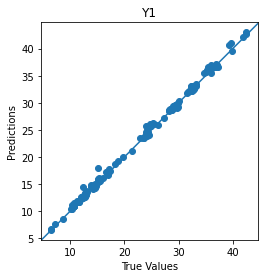

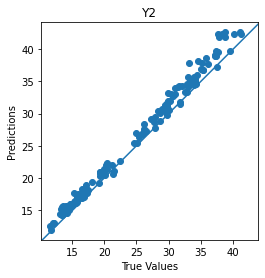

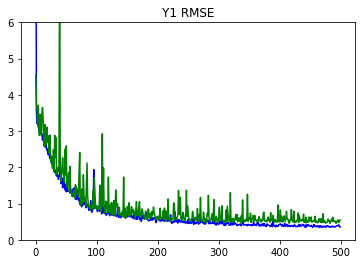

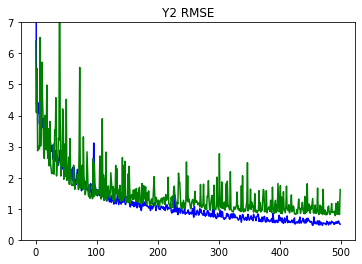

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)